## WorldView Stereopair Processing: SpaceNet Atlanta Example

This notebook demonstrates a stereo processing workflow for WorldView satellite imagery using the NASA Ames Stereo Pipeline (ASP).

The example uses publicly available WorldView-2 data from the [SpaceNet Atlanta dataset](https://spacenet.ai/off-nadir-building-detection/), which provides multi-view imagery at various off-nadir angles over Atlanta, Georgia.

---

### Processing Overview

This notebook covers a basic stereo workflow:

- **Data Retrieval** - Download WorldView imagery from AWS S3
- **Mosaicking Tiles** - Not used here, but how to tile image for full processing later
- **CCD Artifact Correction** - Apply `wv_correct` to fix sensor artifacts
- **Reference DEM Preparation** - Obtain and prepare Copernicus 30m DEM
- **Bundle Adjustment** - Camera model refinement
- **Define Region of Interest** - Select a region of interest for processing
- **Mapprojection** - Project cropped images onto reference DEM
- **Stereo Processing** - Generate DEM from stereopair
- **Visualization with `asp_plot`** - Analyze results and compare with ICESat-2

**Note:** The full SpaceNet images are very large (~35,000 x 55,000 pixels each). To make processing manageable, we will process individual tiles and crop to a smaller region of interest.

For advanced workflows including jitter correction, see [ASP Documentation Section 16.39.9](https://stereopipeline.readthedocs.io/en/latest/tools/jitter_solve.html#example-2-worldview-3-digitalglobe-images-on-earth).

---

## Data Retrieval

### SpaceNet Atlanta Dataset

The [SpaceNet Off-Nadir Building Detection Challenge](https://spacenet.ai/off-nadir-building-detection/) provides WorldView-2 imagery collected over Atlanta, Georgia at multiple viewing angles. This dataset is ideal for demonstrating stereo processing because it includes imagery from various off-nadir angles that can form stereopairs.

The data is hosted on AWS S3 and can be accessed directly via HTTPS without authentication. Available scenes are organized by nadir angle and catalog ID (CATID):

```bash
 $ aws s3 ls --no-sign-request s3://spacenet-dataset/AOIs/AOI_6_Atlanta/
                           PRE metadata/
                           PRE nadir10_catid_1030010003993E00/
                           PRE nadir10_catid_1030010003CAF100/
                           # ...
                           PRE nadir8_catid_10300100023BC100/
```

The `nadirX_catid_YYYY/` directories contain mapprojected orthoimages, which we **cannot use for stereo processing**. Instead, after exploring the available data, we will need to gather the **raw L1B images from the `metadata/` directory**.

### Selecting a Stereopair

For stereo processing, we want two images with:
- Sufficient baseline (convergence angle ~15-45 degrees)
- Good overlap
- Similar illumination conditions

For this example, we select:
- **Image 1**: `nadir7_catid_1030010003D22F00` (near-nadir, ~7 degrees off-nadir)
- **Image 2**: `nadir30_catid_10300100036D5200` (off-nadir, ~30 degrees off-nadir)

This pairing provides a convergence angle of approximately 23 degrees, suitable for stereo reconstruction.

### Download Commands

Create a working directory and download the files with `aws`, ensuring you are gathering the un-processed L1B files from the `metadata/` subdirectory:

```bash
# Create working directory structure
mkdir -p atlanta_stereo/images
cd atlanta_stereo/images

# Sync 1030010003D22F00 (near nadir) scene (Image 1) data
aws s3 --no-sign-request sync s3://spacenet-dataset/AOIs/AOI_6_Atlanta/metadata/1030010003D22F00 aws/1030010003D22F00

# Sync 10300100036D5200 (30 degree) scene (Image 2) data
aws s3 --no-sign-request sync s3://spacenet-dataset/AOIs/AOI_6_Atlanta/metadata/10300100036D5200 aws/10300100036D5200
```

### Examining Contents

The directory contains a number of subdirectories and auxiliary files:

```bash
$ ls -lh aws/10300100036D5200/
total 100K
-rw-r--r-- 1 | 058332886010_01_LAYOUT.JPG
drwxr-xr-x 2 | 058332886010_01_P001_MUL
drwxr-xr-x 2 | 058332886010_01_P001_PAN
drwxr-xr-x 2 | 058332886010_01_P002_MUL
drwxr-xr-x 2 | 058332886010_01_P002_PAN
drwxr-xr-x 2 | 058332886010_01_P003_MUL
drwxr-xr-x 2 | 058332886010_01_P003_PAN
-rw-r--r-- 1 | 058332886010_01_README.TXT
-rw-r--r-- 1 | 058332886010_01_README.XML
drwxr-xr-x 2 | GIS_FILES
```

The `*P00X` subdirectories correspond to individual overlapping tiles of the entire scene. Additionally, the `PAN` and `MUL` variants refer to pan- and multispectral scenes, respectively. The PAN files contain `*P1BS*` in the filename, whereas the multispectral files contain `*M1BS*`. For ASP processing, we will focus on only the PAN images.

An example single tile panchromatic directory looks like:

```bash
$ ls -lh aws/10300100036D5200/058332886010_01_P003_PAN/
total 1.2G
-rw-r--r-- 1 | 09DEC22163735-P1BS-058332886010_01_P003.ATT
-rw-r--r-- 1 | 09DEC22163735-P1BS-058332886010_01_P003-BROWSE.JPG
-rw-r--r-- 1 | 09DEC22163735-P1BS-058332886010_01_P003.EPH
-rw-r--r-- 1 | 09DEC22163735-P1BS-058332886010_01_P003.GEO
-rw-r--r-- 1 | 09DEC22163735-P1BS-058332886010_01_P003.IMD
-rw-r--r-- 1 | 09DEC22163735-P1BS-058332886010_01_P003_README.TXT
-rw-r--r-- 1 | 09DEC22163735-P1BS-058332886010_01_P003.RPB
-rw-r--r-- 1 | 09DEC22163735-P1BS-058332886010_01_P003.TIF
-rw-r--r-- 1 | 09DEC22163735-P1BS-058332886010_01_P003.TIL
-rw-r--r-- 1 | 09DEC22163735-P1BS-058332886010_01_P003.XML
-rw-r--r-- 1 | BASE.TXT
```

There are many auxiliary files delivered, but the important ones for our ASP processing are the `*.TIF` GeoTiff file containing the image, and the `*.XML` metadata file containing RPC information approximating the camera.

## Mosaicking Tiles and Selecting Tile for Processing

### Combining with `dg_mosaic`

While we won't use the full mosaic of all tiles for our first processing example, these will be useful later.

We can use the [`dg_mosaic`](https://stereopipeline.readthedocs.io/en/latest/tools/dg_mosaic.html) tool to accomplish the tiling of cameras and XML camera files:

```bash
cd atlanta_stereo/images/

dg_mosaic aws/1030010003D22F00/*PAN/*P1BS*P00*TIF --output-prefix 1030010003D22F00
dg_mosaic aws/10300100036D5200/*PAN/*P1BS*P00*TIF --output-prefix 10300100036D5200
```

This outputs the full-size, mosaicked camera and image files for each scene at full resolution (denoted by the `.r100.` string in the filename; referring to "100% resolution"). Note the large size, which take a long time to process by ASP:

```bash
$ ls -lh *r100*
-rw------- 1 | 2.4G 10300100036D5200.r100.tif
-rw------- 1 | 887K 10300100036D5200.r100.xml
-rw------- 1 | 2.6G 1030010003D22F00.r100.tif
-rw------- 1 | 900K 1030010003D22F00.r100.xml
```

### Selecting Tiles for Processing

Given the size of the mosaicked scene, it may be preferable to only process a small section of the full, in some area of interest. For this exercise, we will just select a pair of the individual tiles to process.

We can select a pair of tiles with the `GIS_FILES/` directory, which contains `.shp` files for every tile that can be loaded with your GIS:

```bash
cd atlanta_stereo/images

ls -lh aws/*/GIS_FILES/*TILE_SHAPE.shp

-rw-r--r-- 1 | aws/10300100036D5200/GIS_FILES/058332886010_01_TILE_SHAPE.shp
-rw-r--r-- 1 | aws/1030010003D22F00/GIS_FILES/058587060010_01_TILE_SHAPE.shp
```

Opening those in QGIS and inspecting reveals variable overlap between the different tiles of `10300100036D5200` in **red** and `1030010003D22F00` in **orange**:

---

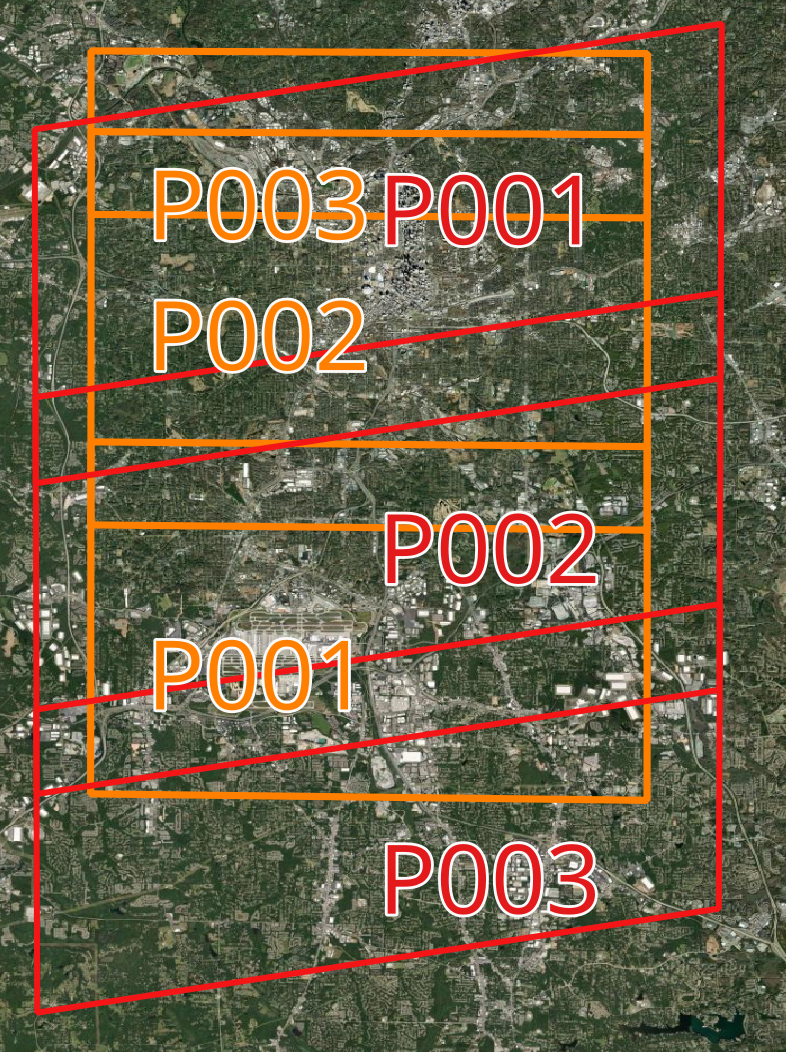

---

As you can see, the similarly named tiles in each image do not at all correspond to ground overlap.

For the processing presented here, we will select `P001` from `1030010003D22F00` and `P002` from `10300100036D5200`, which appear to be tiles that have good overlap of the airport.

To prepare these tiles for processing, we will create some symbolic links, to avoid duplication of the large files but provide some easier names to follow:

```bash
cd atlanta_stereo

ln -s images/aws/1030010003D22F00/*PAN/*P1BS*P001.TIF 1030010003D22F00_P001.tif 
ln -s images/aws/1030010003D22F00/*PAN/*P1BS*P001.XML 1030010003D22F00_P001.xml

ln -s images/aws/10300100036D5200/*PAN/*P1BS*P002.TIF 10300100036D5200_P002.tif
ln -s images/aws/10300100036D5200/*PAN/*P1BS*P002.XML 10300100036D5200_P002.xml

ls
total 28K
lrwxrwxrwx | 10300100036D5200_P002.tif -> images/aws/10300100036D5200/058332886010_01_P002_PAN/09DEC22163734-P1BS-058332886010_01_P002.TIF
lrwxrwxrwx | 10300100036D5200_P002.xml -> images/aws/10300100036D5200/058332886010_01_P002_PAN/09DEC22163734-P1BS-058332886010_01_P002.XML
lrwxrwxrwx | 1030010003D22F00_P001.tif -> images/aws/1030010003D22F00/058587060010_01_P001_PAN/09DEC22163621-P1BS-058587060010_01_P001.TIF
lrwxrwxrwx | 1030010003D22F00_P001.xml -> images/aws/1030010003D22F00/058587060010_01_P001_PAN/09DEC22163621-P1BS-058587060010_01_P001.XML
```

---

## CCD Artifact Correction

WorldView sensors have subpixel misalignments between CCD arrays that can cause discontinuities in DEMs. The [`wv_correct`](https://stereopipeline.readthedocs.io/en/latest/tools/wv_correct.html) tool corrects these artifacts.

WorldView-2 imagery processed after May 26, 2022 has reduced CCD artifacts, and applying `wv_correct` may make results worse. ASP 3.3.0+ automatically detects this and skips correction, so it is recommended to always run `wv_correct` as a precautionary first step in processing. The SpaceNet Atlanta data was processed in 2019, so correction is definitely required.

```bash
cd atlanta_stereo

wv_correct 10300100036D5200_P002.tif 10300100036D5200_P002.xml 10300100036D5200_P002_corr.tif
wv_correct 1030010003D22F00_P001.tif 1030010003D22F00_P001.xml 1030010003D22F00_P001_corr.tif
```

The corrected images will be used for all subsequent processing steps.

---

## Reference DEM Preparation

A reference DEM is required for:
- Mapprojecting the input images
- Validating the output DEM

We use the Copernicus 30m GLO-30 DEM, which provides global coverage with good accuracy.

### Download Copernicus DEM

Using [fetch_dem](https://github.com/uw-cryo/fetch_dem). This requires a free [OpenTopography API key](https://portal.opentopography.org/requestService?service=api) to pass to `-apikey`. The `-extent` argument was gathered from the metadata contained in the L1B imagery and corresponds to the bounding box of the `10300100036D5200` full scene:

```bash
cd atlanta_stereo

python ~/github_repos/fetch_dem/download_global_DEM.py \
  -demtype COP30 \
  -extent "-84.50861222 33.51641356 -84.28547902 33.84685572" \
  -out_fn ref/cop30_atlanta.tif \
  -apikey [YOUR_OPEN_TOPOGRAPHY_API_KEY]
```

### Adjust Vertical Reference

The Copernicus DEM uses EGM2008 geoid heights. ASP requires heights relative to the WGS84 ellipsoid:

```bash
# Convert from EGM2008 geoid to WGS84 ellipsoid heights
dem_geoid --geoid egm2008 --reverse-adjustment -o ref/cop30_atlanta ref/cop30_atlanta.tif

# Rename for clarity
mv ref/cop30_atlanta-adj.tif ref/ref.tif
```

### Reproject

Reproject the DEM to UTM, as all subsequent processing will be in UTM

```bash
proj="+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs"

gdalwarp -r cubic -t_srs "$proj" ref/ref.tif ref/ref-utm.tif
```

---

## Bundle Adjustment

Bundle adjustment refines camera models by minimizing reprojection errors of matched feature points. This step improves stereo correlation quality.

Bundle adjustment must be run on the full tile without any further cropping to a region of interest:

```bash
bundle_adjust \
  --threads 24 \
  --ip-per-image 10000 \
  --tri-weight 0.1 \
  --tri-robust-threshold 0.1 \
  --camera-weight 0 \
  10300100036D5200_P002_corr.tif 1030010003D22F00_P001_corr.tif \
  10300100036D5200_P002.xml 1030010003D22F00_P001.xml \
  -o ba/run
```

**Key parameters:**
- `--ip-per-image 10000`: Detect many interest points for robust matching
- `--tri-weight 0.1`: Weight for triangulation consistency constraint
- `--camera-weight 0`: Allow cameras to move freely (no prior constraint)

**Additional optional parameters:**
- `--ip-detect-method 1`: Use SIFT-like interest point detector
- `--remove-outliers-params '75.0 3.0 20 20'`: Generous outlier filtering for urban scenes with imperfect geometry

---

## Define Region of Interest

The full SpaceNet images are very large. To make processing tractable, we define a region of interest (ROI) to process.

You can determine the overlapping region interactively using `stereo_gui`:

```bash
stereo_gui 1030010003D22F00_P001_corr.tif 10300100036D5200_P002_corr.tif 1030010003D22F00_P001.xml 10300100036D5200_P002.xml
```

Draw a bounding box on the overlap area by holding down `CTRL` and clicking to draw a box, then noting the pixel coordinates in the terminal output.

However, more practically, you can use any other tool to collect appropriate coordinates to define a geographic bounding box for your region of interest. Just be sure the region is contained in the overlapping area of the two selected images.

The `mapproject` tool accepts geographic coordinates with `--t_projwin` (format: `xmin ymin xmax ymax` in the target projection).

For this example, we define a common ROI as:

```bash
# Define the region of interest in UTM Zone 16 N (EPSG:32616) as "xmin ymin xmax ymax" ("western-longitude southern-latitude easter-longitude northern-latitude")
projwin="734280 3724675 740730 3729410"
```

Using a single geographic/projected bounding box is simpler than pixel coordinates because:
- The same ROI works for both images
- `mapproject` automatically determines which source pixels to read
- Easier to define regions based on real-world locations

---

## Mapprojection

Mapprojection orthorectifies the images onto the reference DEM surface. This simplifies stereo correlation by removing most geometric distortions, leaving only parallax due to elevation differences.

We mapproject only the ROI using the bundle-adjusted cameras:

```bash
projwin="734280 3724675 740730 3729410"
proj="+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs"

# Mapproject image 1 (10300100036D5200_P002_corr) to the ROI
mapproject \
  -t rpc \
  --processes 48 \
  --threads 24 \
  --tr 0.5 \
  --t_projwin $projwin \
  --t_srs "$proj" \
  --bundle-adjust-prefix ba/run \
  ref/ref-utm.tif \
  10300100036D5200_P002_corr.tif 10300100036D5200_P002.xml \
  10300100036D5200_P002_corr.map.tif

# Mapproject image 2 (1030010003D22F00_P001_corr) to the same ROI
mapproject \
  -t rpc \
  --processes 48 \
  --threads 24 \
  --tr 0.5 \
  --t_projwin $projwin \
  --t_srs "$proj" \
  --bundle-adjust-prefix ba/run \
  ref/ref-utm.tif \
  1030010003D22F00_P001_corr.tif 1030010003D22F00_P001.xml \
  1030010003D22F00_P001_corr.map.tif
```

**Key parameters:**
- `--tr 0.5`: Output resolution of 0.5 meters (WorldView-2 panchromatic GSD)
- `--t_srs`: Target spatial reference system (UTM Zone 16N for Atlanta)
- `--t_projwin`: Region of interest in projected coordinates (xmin ymin xmax ymax)
- `--bundle-adjust-prefix`: Use the refined camera models from bundle adjustment

---

## Stereo Processing

Run stereo correlation on the mapprojected (and cropped) images to generate a point cloud and DEM:

```bash
parallel_stereo \
  --stereo-algorithm asp_mgm \
  --subpixel-mode 9 \
  --processes 24 \
  --alignment-method none \
  --bundle-adjust-prefix ba/run \
  10300100036D5200_P002_corr.map.tif 1030010003D22F00_P001_corr.map.tif \
  10300100036D5200_P002.xml 1030010003D22F00_P001.xml \
  stereo/run \
  ref/ref-utm.tif
```

**Key parameters:**
- `--stereo-algorithm asp_mgm`: Use ASP's implementation of Semi-Global Matching
- `--subpixel-mode 9`: High-quality subpixel refinement
- `--alignment-method none`: Images are already aligned via mapprojection
- `--bundle-adjust-prefix ba/run`: Use bundle-adjusted camera models

### Generate DEM

```bash
proj="+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs"

point2dem \
  --tr 0.5 \
  --t_srs "$proj" \
  --errorimage \
  stereo/run-PC.tif
```

The `--errorimage` flag produces an intersection error map showing triangulation consistency.

### Compute Difference vs Reference

```bash
geodiff \
  stereo/run-DEM.tif \
  ref/ref-utm.tif \
  -o stereo/run_vs_ref
```

---

## Visualization with `asp_plot`

The sections below demonstrate using `asp_plot` to visualize and validate the stereo processing results.

### Setup

In [ ]:
# Set the base directory for your processing
directory = "/path/to/atlanta_stereo/"
bundle_adjust_directory = "ba/"
stereo_directory = "stereo/"
reference_dem = f"{directory}ref.tif"

In [ ]:
%load_ext autoreload
%autoreload 2

import contextily as ctx

In [ ]:
# Atlanta is in UTM Zone 16N
map_crs = "EPSG:32616"

ctx_kwargs = {
    "crs": map_crs,
    "source": ctx.providers.Esri.WorldImagery,
    "attribution_size": 0,
    "alpha": 0.5,
}

### Full Report Generation

Generate a comprehensive PDF report with a single CLI command:

In [ ]:
!asp_plot \
  --directory $directory \
  --bundle_adjust_directory $bundle_adjust_directory \
  --stereo_directory $stereo_directory \
  --reference_dem $reference_dem \
  --map_crs EPSG:32616 \
  --dem_gsd 0.5 \
  --subset_km 1 \
  --add_basemap True \
  --plot_icesat True \
  --plot_geometry True

---

## Individual Plots

The sections below demonstrate modular usage of `asp_plot` for detailed analysis.

### Processing Parameters

Extract and display the command-line parameters used during processing:

In [ ]:
from asp_plot.processing_parameters import ProcessingParameters

In [ ]:
processing_parameters = ProcessingParameters(
    processing_directory=directory,
    bundle_adjust_directory=bundle_adjust_directory,
    stereo_directory=stereo_directory
)
processing_parameters_dict = processing_parameters.from_log_files()

print(f"Processed on: {processing_parameters_dict['processing_timestamp']}\n")

print(f"Reference DEM: {processing_parameters_dict['reference_dem']}\n")

print(f"Bundle adjustment ({processing_parameters_dict['bundle_adjust_run_time']}):\n")
print(processing_parameters_dict["bundle_adjust"])

print(f"\nStereo ({processing_parameters_dict['stereo_run_time']}):\n")
print(processing_parameters_dict["stereo"])

print(f"\nPoint2dem ({processing_parameters_dict['point2dem_run_time']}):\n")
print(processing_parameters_dict["point2dem"])

### Scene Plots

Visualize the input satellite imagery:

In [ ]:
from asp_plot.scenes import ScenePlotter

In [ ]:
plotter = ScenePlotter(
  directory,
  stereo_directory,
  title="Input Scenes"
)

plotter.plot_scenes()

### Stereo Geometry

Analyze stereo acquisition geometry from XML camera metadata:

In [ ]:
from asp_plot.stereo_geometry import StereoGeometryPlotter

In [ ]:
geometry_plotter = StereoGeometryPlotter(
  directory
)

geometry_plotter.dg_geom_plot()

### Bundle Adjustment Residuals

Visualize bundle adjustment optimization results:

In [ ]:
from asp_plot.bundle_adjust import ReadBundleAdjustFiles, PlotBundleAdjustFiles

In [ ]:
ba_files = ReadBundleAdjustFiles(directory, bundle_adjust_directory)
resid_initial_gdf, resid_final_gdf = ba_files.get_initial_final_residuals_gdfs(residuals_in_meters=True)

In [ ]:
plotter = PlotBundleAdjustFiles(
  [resid_initial_gdf, resid_final_gdf],
  lognorm=True,
  title="Bundle Adjust Initial and Final Residuals (Log Scale)"
)

plotter.plot_n_gdfs(
    column_name="mean_residual",
    cbar_label="Mean residual (px)",
    map_crs=map_crs,
    **ctx_kwargs
)

In [ ]:
plotter.lognorm = False
plotter.title = "Bundle Adjust Initial and Final Residuals (Linear Scale)"

plotter.plot_n_gdfs(
    column_name="mean_residual",
    cbar_label="Mean residual (px)",
    common_clim=False,
    map_crs=map_crs,
    **ctx_kwargs
)

### Stereo DEM Results

Examine the stereo processing results:

In [ ]:
from asp_plot.stereo import StereoPlotter

In [ ]:
plotter = StereoPlotter(
  directory, 
  stereo_directory,
  reference_dem=reference_dem,
  dem_gsd=0.5,
)

plotter.title = "Stereo DEM Results"

plotter.plot_dem_results()

In [ ]:
plotter.title = "Hillshade with Details"

plotter.plot_detailed_hillshade(
  subset_km=1,
)

In [ ]:
plotter.title = "Stereo Match Points"

plotter.plot_match_points()

In [ ]:
plotter.title = "Disparity (meters)"

plotter.plot_disparity(
  unit="meters",
  quiver=True,
)

### ICESat-2 Altimetry Validation

Compare the ASP DEM with ICESat-2 ATL06-SR altimetry data:

In [ ]:
from datetime import datetime
from asp_plot.altimetry import Altimetry

In [ ]:
icesat = Altimetry(
  directory=directory,
  dem_fn=plotter.dem_fn
)

In [ ]:
# Request ATL06-SR data for multiple processing levels
icesat.request_atl06sr_multi_processing(
    processing_levels=["all", "ground"],
    save_to_parquet=True,
)

In [ ]:
# Filter out water bodies
icesat.filter_esa_worldcover(filter_out="water")

In [ ]:
# Apply temporal filters around the acquisition date
# SpaceNet Atlanta imagery was collected on December 22, 2009
icesat_filter_date = "2009-12-22"
icesat_filter_date = datetime.strptime(icesat_filter_date, "%Y-%m-%d").date()

icesat.predefined_temporal_filter_atl06sr(date=icesat_filter_date)

In [ ]:
# Map view of ICESat-2 vs DEM differences
icesat.mapview_plot_atl06sr_to_dem(
    key="ground_seasonal",
    map_crs=map_crs,
    **ctx_kwargs,
)

In [ ]:
# Histogram of DEM vs ICESat-2 differences
icesat.histogram(
    key="ground_seasonal",
    plot_aligned=False,
)

In [ ]:
# Run alignment report to assess DEM quality
icesat.alignment_report(
    processing_level="ground",
    minimum_points=100,
    agreement_threshold=0.25,
)

In [ ]:
icesat.alignment_report_df

---

## Next Steps

This notebook demonstrated a basic stereo workflow with cropped images. For more advanced processing:

1. **Full-resolution processing**: Remove the crop windows to process the entire image (requires significant compute resources)

2. **Jitter correction**: For highest quality DEMs, apply jitter correction following [ASP Documentation Section 16.39.9](https://stereopipeline.readthedocs.io/en/latest/tools/jitter_solve.html#example-2-worldview-3-digitalglobe-images-on-earth)

3. **DEM alignment**: Use `pc_align` to align the stereo DEM to ICESat-2 or the reference DEM for improved absolute accuracy

4. **Multi-view stereo**: Process additional image pairs from the SpaceNet dataset and merge the resulting DEMs